In [1]:
import keras
import quandl
import numpy as np

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import keras.backend as K
from sklearn.model_selection import KFold

%matplotlib inline

Using TensorFlow backend.


In [2]:
#data = quandl.get('BCHARTS/BITFINEXUSD') -> OLD BUGGY DATASET (OBD)
#data = quandl.get('BITFINEX/BTCUSD')
data = quandl.get('BITFINEX/XRPBTC')

In [3]:
data.head()

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2017-05-19,0.000200,0.000130,0.000164,0.000169,0.000159,0.000169,1.133802e+06
2017-05-20,0.000189,0.000147,0.000168,0.000168,0.000167,0.000169,4.924474e+06
2017-05-21,0.000178,0.000160,0.000163,0.000164,0.000162,0.000163,3.390939e+06
2017-05-22,0.000165,0.000115,0.000141,0.000141,0.000140,0.000141,8.063178e+06
2017-05-23,0.000159,0.000130,0.000145,0.000144,0.000143,0.000146,2.929714e+06


In [4]:
print("data shape before embedding:",data.shape)

mean = data.mean(axis=0)
std = data.std(axis=0)

# zscore normalization
data = ( data - mean ) / std

# # of days past we want skynet to see
d = 7

X = np.zeros((data.shape[0],d,data.shape[1]))

# embedding d days in each DP (deslocamento)
for i in range(d,data.shape[0]):
    X[i,:,:] = data.iloc[i-d:i].values

#removing first d lines, this ones didn't have d days past
X = X[d:,:,:]

print("data shape after embedding:",X.shape)

data shape before embedding: (226, 7)
data shape after embedding: (219, 7, 7)


In [5]:
# creating labels
Y = data['Mid'] - data.shift(1)['Mid']

Y = Y > 0

Y.shape

(226,)

In [6]:
#removing first line: second label refers to first DP ($$ delta)
Y = Y[1:]

#removing first d days because of the embedding
Y = Y[d:]

In [7]:
#removing last registry from X, since we had to remove first DP from Y
#specifying other dimensions for good practices - TY @lucasosouza
X = X[: -1,:,:]

In [8]:
# checking shapes
Y.shape, X.shape

((218,), (218, 7, 7))

In [9]:
# Adding channel layer, as expected by the convnet
X = X.reshape((Y.shape[0],d,7,1))
X.shape

(218, 7, 7, 1)

In [10]:
# train / test split
#X_train = X[:-300,:,:,:]
#X_test = X[-300:,:,:,:]
#Y_train = Y[:-300]
#Y_test = Y[-300:]

# split the data 
kf = KFold(n_splits=8,shuffle=True,random_state=0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #print("TRAIN:", train_index, "TEST:", test_index)

In [16]:
def model(input_shape):
    
    X_input = Input(input_shape)
    
    #padding same so we dont lose size
    X = Conv2D(10,(3,3), strides=(1,1),name="conv0", padding="same")(X_input)
    X = BatchNormalization(axis=3,name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool0')(X)
    
    #Second conv
    X = Conv2D(30,(2,2), strides=(1,1),name="conv1", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2),name='max_pool1')(X)
    
    #Third conv
    X = Conv2D(50,(1,1), strides=(1,1),name="conv2", padding="same")(X)
    X = BatchNormalization(axis=3,name='bn2')(X)
    X = Activation('relu')(X)
    
    #fcs
    X = Flatten()(X)
    X = Dense(200,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(100,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(50,activation="relu")(X)
    #X = Dropout(rate=0.3, seed=0)(X)
    X = Dense(1,activation="sigmoid")(X)
    
    model = Model(inputs=X_input,outputs=X, name="model1")
    
    return model

In [17]:
#training the model, time for witchcraft
model = model(X[0].shape)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])

model.fit(x = X_train, y = Y_train, epochs = 300, batch_size = 8,verbose=1)

Epoch 1/300
191/191 [==============================] - 1s 3ms/step - loss: 0.7005 - acc: 0.5497
Epoch 2/300
191/191 [==============================] - 0s 814us/step - loss: 0.6927 - acc: 0.5812
Epoch 3/300
191/191 [==============================] - 0s 783us/step - loss: 0.6698 - acc: 0.6021
Epoch 4/300
191/191 [==============================] - 0s 813us/step - loss: 0.6674 - acc: 0.5969
Epoch 5/300
191/191 [==============================] - 0s 990us/step - loss: 0.6760 - acc: 0.6021
Epoch 6/300
191/191 [==============================] - 0s 784us/step - loss: 0.6521 - acc: 0.6073
Epoch 7/300
191/191 [==============================] - 0s 822us/step - loss: 0.6375 - acc: 0.6283
Epoch 8/300
191/191 [==============================] - 0s 792us/step - loss: 0.6192 - acc: 0.6597
Epoch 9/300
191/191 [==============================] - 0s 855us/step - loss: 0.6690 - acc: 0.5969
Epoch 10/300
191/191 [==============================] - 0s 823us/step - loss: 0.6577 - acc: 0.6126
Epoch 11/300
191/191 

191/191 [==============================] - 0s 779us/step - loss: 0.4180 - acc: 0.7539
Epoch 84/300
191/191 [==============================] - 0s 727us/step - loss: 0.4830 - acc: 0.7696
Epoch 85/300
191/191 [==============================] - 0s 684us/step - loss: 0.4986 - acc: 0.7120
Epoch 86/300
191/191 [==============================] - 0s 749us/step - loss: 0.4426 - acc: 0.7853
Epoch 87/300
191/191 [==============================] - 0s 782us/step - loss: 0.4672 - acc: 0.7539
Epoch 88/300
191/191 [==============================] - 0s 776us/step - loss: 0.4457 - acc: 0.7644
Epoch 89/300
191/191 [==============================] - 0s 733us/step - loss: 0.5021 - acc: 0.7277
Epoch 90/300
191/191 [==============================] - 0s 715us/step - loss: 0.4404 - acc: 0.7853
Epoch 91/300
191/191 [==============================] - 0s 806us/step - loss: 0.4078 - acc: 0.8220
Epoch 92/300
191/191 [==============================] - 0s 683us/step - loss: 0.4503 - acc: 0.7749
Epoch 93/300
191/191 [=

191/191 [==============================] - 0s 872us/step - loss: 0.3214 - acc: 0.8586
Epoch 166/300
191/191 [==============================] - 0s 871us/step - loss: 0.2952 - acc: 0.8743
Epoch 167/300
191/191 [==============================] - 0s 876us/step - loss: 0.3224 - acc: 0.8743
Epoch 168/300
191/191 [==============================] - 0s 948us/step - loss: 0.2889 - acc: 0.8586
Epoch 169/300
191/191 [==============================] - 0s 885us/step - loss: 0.3379 - acc: 0.8482
Epoch 170/300
191/191 [==============================] - 0s 925us/step - loss: 0.2835 - acc: 0.8586
Epoch 171/300
191/191 [==============================] - 0s 864us/step - loss: 0.3576 - acc: 0.8586
Epoch 172/300
191/191 [==============================] - 0s 978us/step - loss: 0.2695 - acc: 0.8848
Epoch 173/300
191/191 [==============================] - 0s 896us/step - loss: 0.2796 - acc: 0.8743
Epoch 174/300
191/191 [==============================] - 0s 982us/step - loss: 0.3674 - acc: 0.8429
Epoch 175/300


191/191 [==============================] - 0s 970us/step - loss: 0.3330 - acc: 0.8534
Epoch 248/300
191/191 [==============================] - 0s 915us/step - loss: 0.2495 - acc: 0.8691
Epoch 249/300
191/191 [==============================] - 0s 964us/step - loss: 0.2196 - acc: 0.8953
Epoch 250/300
191/191 [==============================] - 0s 854us/step - loss: 0.1597 - acc: 0.9372
Epoch 251/300
191/191 [==============================] - 0s 995us/step - loss: 0.1904 - acc: 0.8953
Epoch 252/300
191/191 [==============================] - 0s 955us/step - loss: 0.1957 - acc: 0.9110
Epoch 253/300
191/191 [==============================] - 0s 869us/step - loss: 0.3701 - acc: 0.8482
Epoch 254/300
191/191 [==============================] - 0s 832us/step - loss: 0.3216 - acc: 0.8534
Epoch 255/300
191/191 [==============================] - 0s 884us/step - loss: 0.2086 - acc: 0.9058
Epoch 256/300
191/191 [==============================] - 0s 944us/step - loss: 0.2214 - acc: 0.8848
Epoch 257/300


In [18]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print("Loss = " + str(preds[0]))
print("Acc = " + str(preds[1]))

27/27 [==============================] - 0s 4ms/step

Loss = 1.77673852444
Acc = 0.629629611969


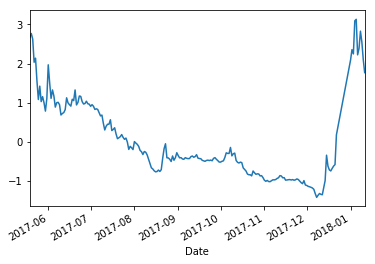

In [14]:
data['Mid'].plot()
